In [1]:
from google.colab import files
uploaded = files.upload()

Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv


In [3]:
import pandas as pd
import numpy as np
col_names = ["sentiment","id","date","query","user","text"]

# We'll sample ~40k rows balanced between negative(0) and positive(4)
sample_target = 40000
per_class = sample_target // 2
chunksize = 200000
rng = np.random.RandomState(42)

neg_samples, pos_samples = [], []
# TODO(b/340318480): Use the path provided in the `uploaded` variable.
path = '/content/training.1600000.processed.noemoticon.csv'
for chunk in pd.read_csv(path, header=None, names=col_names, usecols=[0,5],
                         chunksize=chunksize, encoding="ISO-8859-1", on_bad_lines="skip"):
    chunk = chunk[chunk["sentiment"].isin([0,4])].dropna(subset=["text"])
    neg = chunk[chunk["sentiment"]==0]
    pos = chunk[chunk["sentiment"]==4]
    if sum([len(x) for x in neg_samples]) < per_class and len(neg)>0:
        take = min(per_class - sum(len(x) for x in neg_samples), len(neg))
        neg_samples.append(neg.sample(n=take, random_state=rng.randint(0,1_000_000)))
    if sum([len(x) for x in pos_samples]) < per_class and len(pos)>0:
        take = min(per_class - sum(len(x) for x in pos_samples), len(pos))
        pos_samples.append(pos.sample(n=take, random_state=rng.randint(0,1_000_000)))
    if sum(len(x) for x in neg_samples) >= per_class and sum(len(x) for x in pos_samples) >= per_class:
        break

df = pd.concat(neg_samples + pos_samples, ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
df["label"] = (df["sentiment"] == 4).astype(int)
print(df.shape)   # expect ~40k x columns
# Why balanced sample? ensures the learning signals for both classes are visible and speeds up iterations.

# Clean text & extract simple signals
# python
# Copy
# Edit
import re
url_pat = re.compile(r"http\S+|www\.\S+")
mention_pat = re.compile(r"@\w+")
hashtag_pat = re.compile(r"#(\w+)")

def clean_text(s):
    s = str(s).lower()
    s = url_pat.sub(" URL ", s)
    s = mention_pat.sub(" USER ", s)
    s = hashtag_pat.sub(r"\1", s)
    s = re.sub(r"[^a-z0-9\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["clean"] = df["text"].apply(clean_text)
df["has_url"] = df["text"].str.contains(url_pat)
df["has_user"] = df["text"].str.contains(mention_pat)
df["hashtags"] = df["text"].apply(lambda t: hashtag_pat.findall(str(t).lower()))
df["length_chars"] = df["text"].astype(str).str.len()
df["length_words"] = df["clean"].str.split().apply(len)

/tmp/ipython-input-3622251113.py:14: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, header=None, names=col_names, usecols=[0,5],


(40000, 3)


label
1    20000
0    20000
Name: count, dtype: int64


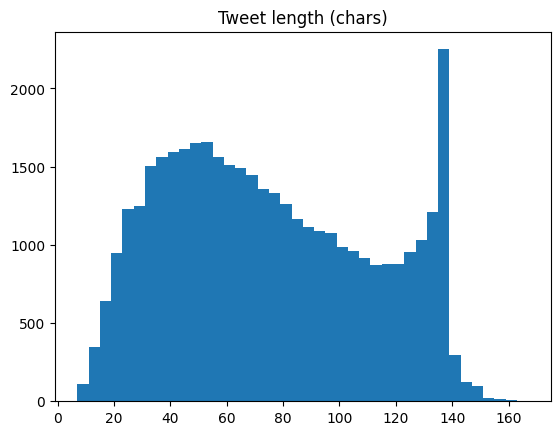

      length_chars               length_words              
              mean median  count         mean median  count
label                                                      
0          75.3026   71.0  20000     13.42685   12.0  20000
1          74.3856   69.0  20000     12.32480   11.0  20000
       has_url  has_user
label                   
0      0.03110   0.39740
1      0.06185   0.54765


In [4]:
# class balance
print(df["label"].value_counts())

# length distribution
import matplotlib.pyplot as plt
plt.hist(df["length_chars"], bins=40); plt.title("Tweet length (chars)"); plt.show()

# average length by class
print(df.groupby("label")[["length_chars","length_words"]].agg(["mean","median","count"]))

# percent with url/hashtag/user by class
print(df.groupby("label")[["has_url","has_user"]].mean())


In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer(stop_words="english", min_df=5)
Xc = cv.fit_transform(df["clean"])
features = np.array(cv.get_feature_names_out())

# sum counts per class
neg_mask = df["label"]==0
pos_mask = df["label"]==1

neg_counts = Xc[neg_mask.values].sum(axis=0).A1
pos_counts = Xc[pos_mask.values].sum(axis=0).A1


top_n = 20
top_pos = features[np.argsort(pos_counts)[-top_n:][::-1]]
top_neg = features[np.argsort(neg_counts)[-top_n:][::-1]]
print("Top pos:", top_pos[:10])
print("Top neg:", top_neg[:10])

Top pos: ['just' 'good' 'day' 'quot' 'love' 'like' 'thanks' 'lol' 'time' 'today']
Top neg: ['just' 'work' 'like' 'day' 'today' 'got' 'going' 'don' 'im' 'miss']


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_val, y_train, y_val = train_test_split(df["clean"], df["label"], test_size=0.2, stratify=df["label"], random_state=42)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, stop_words="english", max_features=50000)),
    ("clf", LogisticRegression(max_iter=1000)),
])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_val)
proba = pipe.predict_proba(X_val)[:,1]

print("Accuracy:", metrics.accuracy_score(y_val, pred))
print("Precision:", metrics.precision_score(y_val, pred))
print("Recall:", metrics.recall_score(y_val, pred))
print("F1:", metrics.f1_score(y_val, pred))
print("AUC:", metrics.roc_auc_score(y_val, proba))

Accuracy: 0.743
Precision: 0.734896085065249
Recall: 0.76025
F1: 0.7473580732366675
AUC: 0.825812


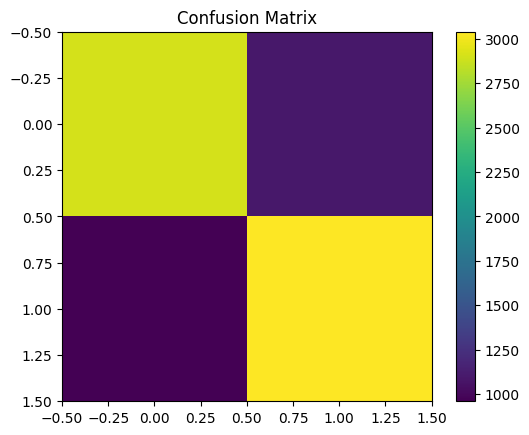

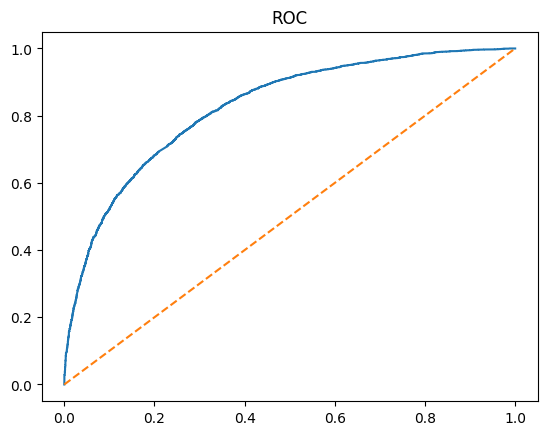

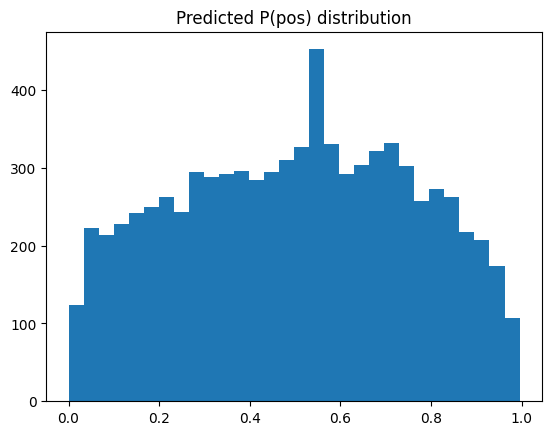

In [8]:
# Confusion matrix
cm = metrics.confusion_matrix(y_val, pred)
plt.imshow(cm, interpolation="nearest"); plt.title("Confusion Matrix"); plt.colorbar(); plt.show()

# ROC
fpr, tpr, _ = metrics.roc_curve(y_val, proba)
plt.plot(fpr,tpr); plt.plot([0,1],[0,1], linestyle="--"); plt.title("ROC"); plt.show()

# Probability histogram
plt.hist(proba, bins=30); plt.title("Predicted P(pos) distribution"); plt.show()